# Mask R-CNN - Train on Shapes Dataset


This notebook shows how to train Mask R-CNN on your own dataset. To keep things simple we use a synthetic dataset of shapes (squares, triangles, and circles) which enables fast training. You'd still need a GPU, though, because the network backbone is a Resnet101, which would be too slow to train on a CPU. On a GPU, you can start to get okay-ish results in a few minutes, and good results in less than an hour.

The code of the *Shapes* dataset is included below. It generates images on the fly, so it doesn't require downloading any data. And it can generate images of any size, so we pick a small image size to train faster. 

In [1]:
import os
import warnings
warnings.filterwarnings('ignore')
import sys
import random
import math
import re
import time
import numpy as np

import tensorflow as tf
from keras.backend.tensorflow_backend import set_session
config = tf.ConfigProto()
config.gpu_options.allow_growth = True
set_session(tf.Session(config=config))

from keras.backend import clear_session
import gc
import cv2
import matplotlib
import matplotlib.pyplot as plt

from config import Config
import utils
import model as modellib
import visualize
import glob
from tqdm import tqdm
from model import log

%matplotlib inline 

# Root directory of the project
ROOT_DIR = os.getcwd()

# Directory to save logs and trained model
MODEL_DIR = os.path.join(ROOT_DIR, "logs")

# Local path to trained weights file
COCO_MODEL_PATH = os.path.join(ROOT_DIR, "mask_rcnn_coco.h5")
# Download COCO trained weights from Releases if needed
if not os.path.exists(COCO_MODEL_PATH):
    utils.download_trained_weights(COCO_MODEL_PATH)

Using TensorFlow backend.


## Configurations

In [2]:
class NucleiConfig(Config):
    """Configuration for training on the toy shapes dataset.
    Derives from the base Config class and overrides values specific
    to the toy shapes dataset.
    """
    # Give the configuration a recognizable name
    NAME = "nuclei"

    # Train on 1 GPU and 8 images per GPU. We can put multiple images on each
    # GPU because the images are small. Batch size is 8 (GPUs * images/GPU).
    GPU_COUNT = 1
    IMAGES_PER_GPU = 2

    # Number of classes (including background)
    NUM_CLASSES = 1 + 1  # background + 1 nuclei class

    # Use small images for faster training. Set the limits of the small side
    # the large side, and that determines the image shape.
    IMAGE_MIN_DIM = 256
    IMAGE_MAX_DIM = 256

    # Use smaller anchors because our image and objects are small
    RPN_ANCHOR_SCALES = (8, 16, 32, 64, 128)  # anchor side in pixels

    # Reduce training ROIs per image because the images are small and have
    # few objects. Aim to allow ROI sampling to pick 33% positive ROIs.
    TRAIN_ROIS_PER_IMAGE = 32
    
    TRAIN_DATASET_PATH = "./dataset/stage1_train"
    TEST_DATASET_PATH = "./dataset/stage1_test"
    VAL_DATASET_PATH = "./dataset/stage1_val" # need to split from stage1_train manually
    
    USE_MINI_MASK = True # This cause zero area bbox RE?!
    
config = NucleiConfig()
config.display()


Configurations:
BACKBONE_SHAPES                [[64 64]
 [32 32]
 [16 16]
 [ 8  8]
 [ 4  4]]
BACKBONE_STRIDES               [4, 8, 16, 32, 64]
BATCH_SIZE                     2
BBOX_STD_DEV                   [0.1 0.1 0.2 0.2]
DETECTION_MAX_INSTANCES        100
DETECTION_MIN_CONFIDENCE       0.7
DETECTION_NMS_THRESHOLD        0.3
GPU_COUNT                      1
IMAGES_PER_GPU                 2
IMAGE_MAX_DIM                  256
IMAGE_MIN_DIM                  256
IMAGE_PADDING                  True
IMAGE_SHAPE                    [256 256   3]
LEARNING_MOMENTUM              0.9
LEARNING_RATE                  0.001
MASK_POOL_SIZE                 14
MASK_SHAPE                     [28, 28]
MAX_GT_INSTANCES               100
MEAN_PIXEL                     [123.7 116.8 103.9]
MINI_MASK_SHAPE                (56, 56)
NAME                           nuclei
NUM_CLASSES                    2
POOL_SIZE                      7
POST_NMS_ROIS_INFERENCE        1000
POST_NMS_ROIS_TRAINING         2000
ROI_

## Notebook Preferences

In [3]:
def get_ax(rows=1, cols=1, size=8):
    """Return a Matplotlib Axes array to be used in
    all visualizations in the notebook. Provide a
    central point to control graph sizes.
    
    Change the default size attribute to control the size
    of rendered images
    """
    _, ax = plt.subplots(rows, cols, figsize=(size*cols, size*rows))
    return ax

## Dataset

Create a synthetic dataset

Extend the Dataset class and add a method to load the shapes dataset, `load_shapes()`, and override the following methods:

* load_image()
* load_mask()
* image_reference()

In [4]:
class NucleiDataset(utils.Dataset):
    """
    nuclei dataset
    """
    
    def __init__(self, root, get_masks=True):
        super(NucleiDataset, self).__init__() # call constructor of super class
        
        from get_image_size import get_image_size
        self.root = root
        self.get_masks = get_masks
        path = self.root + '/*'
        path_list = glob.glob(path)
        for n, subdir in tqdm(enumerate(path_list), total=len(path_list)):
            image_path = str(glob.glob(subdir+'/images/*.png')[0])
            width, height = get_image_size(image_path)
            _, filename_ = os.path.split(image_path)
            dataset_id , _ = os.path.splitext(filename_)
            if self.get_masks:
                mask_paths = list(map(str, list(glob.glob(subdir+'/masks/*.png'))))
                self.add_image('nuclei', image_id=n, path=image_path, dataset_id=dataset_id, width=width, height=height, mask_paths=mask_paths)
            else:
                self.add_image('nuclei', image_id=n, path=image_path, dataset_id=dataset_id, width=width, height=height)
                
        # Add classes, only 2 class: BG(0) / nuclei(1)
        self.add_class("nuclei", 1, "nuclei")
                
        #mask = cv2.imread(mask_path, cv2.IMREAD_GRAYSCALE)
        #assert mask.ndim == 2
        #(ymin, xmin, ymax, xmax) = regionprops((mask>0).astype(np.int32), cache=True)[0].bbox

    def load_image(self, image_id):
        """Generate an image from the specs of the given image ID.
        Typically this function loads the image from a file, but
        in this case it generates the image on the fly from the
        specs in image_info.
        """
        info = self.image_info[image_id]
        image = cv2.imread(info['path'], cv2.IMREAD_COLOR)[...,:3] # BGR color space
        image = image[...,::-1] # BGR -> RGB
        return image

    def image_reference(self, image_id):
        """Return the kaggle_id of the image."""
        info = self.image_info[image_id]
        if info["source"] == "nuclei":
            return info["kaggle_id"]
        else:
            super(self.__class__).image_reference(self, image_id)

    def load_mask(self, image_id):
        """Generate instance masks for shapes of the given image ID.
        """
        info = self.image_info[image_id]
        mask_paths = info['mask_paths']
        count = len(mask_paths)
        mask = np.zeros([info['height'], info['width'], count], dtype=np.uint8)
        for i, mask_path in enumerate(mask_paths):
            mask_ = (cv2.imread(mask_path, cv2.IMREAD_GRAYSCALE)>0).astype(np.uint8) # [0,1]
            mask[..., i] = mask_
        # Handle occlusions
        occlusion = np.logical_not(mask[:, :, -1]).astype(np.uint8)
        for i in range(count-2, -1, -1):
            mask[:, :, i] = mask[:, :, i] * occlusion
            occlusion = np.logical_and(occlusion, np.logical_not(mask[:, :, i]))
        return mask, np.ones(count, dtype=np.int32)


In [5]:
# Training dataset
dataset_train = NucleiDataset(config.TRAIN_DATASET_PATH, get_masks=True)
dataset_train.prepare()

# Validation dataset
dataset_val = NucleiDataset(config.VAL_DATASET_PATH, get_masks=True)
dataset_val.prepare()

100%|██████████| 65/65 [00:00<00:00, 3386.37it/s]


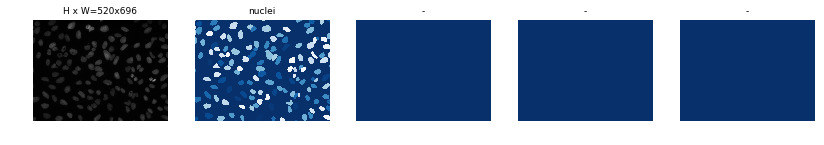

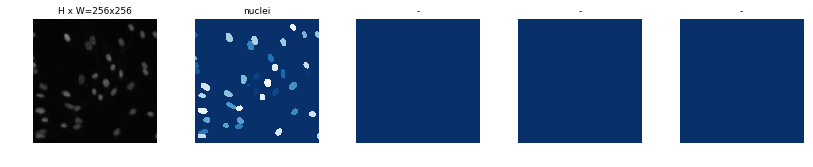

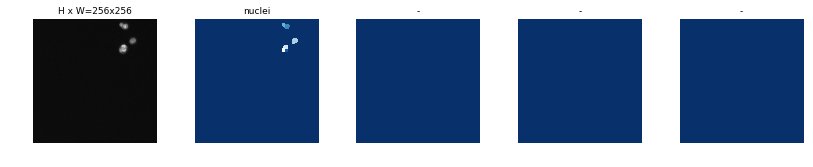

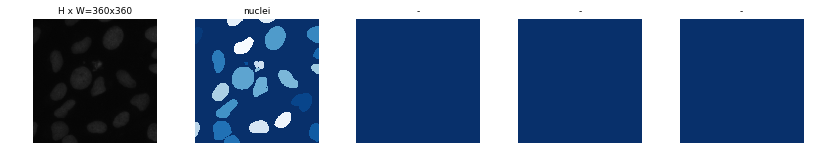

In [6]:
# Load and display random samples
image_ids = np.random.choice(dataset_train.image_ids, 4)
for image_id in image_ids:
    image = dataset_train.load_image(image_id)
    mask, class_ids = dataset_train.load_mask(image_id)
    visualize.display_top_masks(image, mask, class_ids, dataset_train.class_names)

## Ceate Model

In [7]:
# Create model in training mode
model = modellib.MaskRCNN(mode="training", config=config,
                          model_dir=MODEL_DIR)

In [8]:
# Which weights to start with?
init_with = "coco"  # imagenet, coco, or last

if init_with == "imagenet":
    model.load_weights(model.get_imagenet_weights(), by_name=True)
elif init_with == "coco":
    # Load weights trained on MS COCO, but skip layers that
    # are different due to the different number of classes
    # See README for instructions to download the COCO weights
    model.load_weights(COCO_MODEL_PATH, by_name=True,
                       exclude=["mrcnn_class_logits", "mrcnn_bbox_fc", 
                                "mrcnn_bbox", "mrcnn_mask"])
elif init_with == "last":
    # Load the last model you trained and continue training
    model.load_weights(model.find_last()[1], by_name=True)

## Training

Train in two stages:
1. Only the heads. Here we're freezing all the backbone layers and training only the randomly initialized layers (i.e. the ones that we didn't use pre-trained weights from MS COCO). To train only the head layers, pass `layers='heads'` to the `train()` function.

2. Fine-tune all layers. For this simple example it's not necessary, but we're including it to show the process. Simply pass `layers="all` to train all layers.

In [9]:
# Train the head branches
# Passing layers="heads" freezes all layers except the head
# layers. You can also pass a regular expression to select
# which layers to train by name pattern.
model.train(dataset_train, dataset_val, 
            learning_rate=config.LEARNING_RATE, 
            epochs=1, 
            layers='heads')


Starting at epoch 0. LR=0.001

Checkpoint Path: /home/peter/Mask_RCNN/logs/nuclei20180305T0244/mask_rcnn_nuclei_{epoch:04d}.h5
Selecting layers to train
fpn_c5p5               (Conv2D)
fpn_c4p4               (Conv2D)
fpn_c3p3               (Conv2D)
fpn_c2p2               (Conv2D)
fpn_p5                 (Conv2D)
fpn_p2                 (Conv2D)
fpn_p3                 (Conv2D)
fpn_p4                 (Conv2D)
In model:  rpn_model
    rpn_conv_shared        (Conv2D)
    rpn_class_raw          (Conv2D)
    rpn_bbox_pred          (Conv2D)
mrcnn_mask_conv1       (TimeDistributed)
mrcnn_mask_bn1         (TimeDistributed)
mrcnn_mask_conv2       (TimeDistributed)
mrcnn_mask_bn2         (TimeDistributed)
mrcnn_class_conv1      (TimeDistributed)
mrcnn_class_bn1        (TimeDistributed)
mrcnn_mask_conv3       (TimeDistributed)
mrcnn_mask_bn3         (TimeDistributed)
mrcnn_class_conv2      (TimeDistributed)
mrcnn_class_bn2        (TimeDistributed)
mrcnn_mask_conv4       (TimeDistributed)
mrcnn_mask

In [10]:
# Fine tune all layers
# Passing layers="all" trains all layers. You can also 
# pass a regular expression to select which layers to
# train by name pattern.
model.train(dataset_train, dataset_val, 
            learning_rate=config.LEARNING_RATE / 10,
            epochs=50, 
            layers="all")


Starting at epoch 1. LR=0.0001

Checkpoint Path: /home/peter/Mask_RCNN/logs/nuclei20180305T0244/mask_rcnn_nuclei_{epoch:04d}.h5
Selecting layers to train
conv1                  (Conv2D)
bn_conv1               (BatchNorm)
res2a_branch2a         (Conv2D)
bn2a_branch2a          (BatchNorm)
res2a_branch2b         (Conv2D)
bn2a_branch2b          (BatchNorm)
res2a_branch2c         (Conv2D)
res2a_branch1          (Conv2D)
bn2a_branch2c          (BatchNorm)
bn2a_branch1           (BatchNorm)
res2b_branch2a         (Conv2D)
bn2b_branch2a          (BatchNorm)
res2b_branch2b         (Conv2D)
bn2b_branch2b          (BatchNorm)
res2b_branch2c         (Conv2D)
bn2b_branch2c          (BatchNorm)
res2c_branch2a         (Conv2D)
bn2c_branch2a          (BatchNorm)
res2c_branch2b         (Conv2D)
bn2c_branch2b          (BatchNorm)
res2c_branch2c         (Conv2D)
bn2c_branch2c          (BatchNorm)
res3a_branch2a         (Conv2D)
bn3a_branch2a          (BatchNorm)
res3a_branch2b         (Conv2D)
bn3a_bran

303/303 [==============================] - 195s 643ms/step - loss: 2.0002 - rpn_class_loss: 0.1914 - rpn_bbox_loss: 0.8204 - mrcnn_class_loss: 0.2207 - mrcnn_bbox_loss: 0.3311 - mrcnn_mask_loss: 0.4365 - val_loss: 1.8550 - val_rpn_class_loss: 0.1785 - val_rpn_bbox_loss: 0.7504 - val_mrcnn_class_loss: 0.2279 - val_mrcnn_bbox_loss: 0.2998 - val_mrcnn_mask_loss: 0.3984
Epoch 3/50
303/303 [==============================] - 159s 526ms/step - loss: 1.9035 - rpn_class_loss: 0.1735 - rpn_bbox_loss: 0.8021 - mrcnn_class_loss: 0.2050 - mrcnn_bbox_loss: 0.3035 - mrcnn_mask_loss: 0.4195 - val_loss: 1.7348 - val_rpn_class_loss: 0.1594 - val_rpn_bbox_loss: 0.7208 - val_mrcnn_class_loss: 0.2044 - val_mrcnn_bbox_loss: 0.2742 - val_mrcnn_mask_loss: 0.3760
Epoch 4/50
303/303 [==============================] - 160s 530ms/step - loss: 1.8336 - rpn_class_loss: 0.1585 - rpn_bbox_loss: 0.7758 - mrcnn_class_loss: 0.2027 - mrcnn_bbox_loss: 0.2936 - mrcnn_mask_loss: 0.4030 - val_loss: 1.6978 - val_rpn_class_los

Epoch 24/50
303/303 [==============================] - 157s 518ms/step - loss: 1.3914 - rpn_class_loss: 0.0972 - rpn_bbox_loss: 0.5144 - mrcnn_class_loss: 0.1811 - mrcnn_bbox_loss: 0.2384 - mrcnn_mask_loss: 0.3602 - val_loss: 1.2399 - val_rpn_class_loss: 0.0888 - val_rpn_bbox_loss: 0.4471 - val_mrcnn_class_loss: 0.1734 - val_mrcnn_bbox_loss: 0.2186 - val_mrcnn_mask_loss: 0.3120
Epoch 25/50
303/303 [==============================] - 163s 537ms/step - loss: 1.3819 - rpn_class_loss: 0.0969 - rpn_bbox_loss: 0.5192 - mrcnn_class_loss: 0.1755 - mrcnn_bbox_loss: 0.2362 - mrcnn_mask_loss: 0.3541 - val_loss: 1.2448 - val_rpn_class_loss: 0.0849 - val_rpn_bbox_loss: 0.4308 - val_mrcnn_class_loss: 0.1943 - val_mrcnn_bbox_loss: 0.2292 - val_mrcnn_mask_loss: 0.3056
Epoch 26/50
303/303 [==============================] - 158s 520ms/step - loss: 1.3665 - rpn_class_loss: 0.0968 - rpn_bbox_loss: 0.5036 - mrcnn_class_loss: 0.1743 - mrcnn_bbox_loss: 0.2384 - mrcnn_mask_loss: 0.3534 - val_loss: 1.2047 - val

303/303 [==============================] - 156s 514ms/step - loss: 1.2676 - rpn_class_loss: 0.0855 - rpn_bbox_loss: 0.4557 - mrcnn_class_loss: 0.1544 - mrcnn_bbox_loss: 0.2260 - mrcnn_mask_loss: 0.3461 - val_loss: 1.1032 - val_rpn_class_loss: 0.0742 - val_rpn_bbox_loss: 0.3740 - val_mrcnn_class_loss: 0.1646 - val_mrcnn_bbox_loss: 0.1957 - val_mrcnn_mask_loss: 0.2946
Epoch 46/50
303/303 [==============================] - 154s 507ms/step - loss: 1.2509 - rpn_class_loss: 0.0829 - rpn_bbox_loss: 0.4483 - mrcnn_class_loss: 0.1614 - mrcnn_bbox_loss: 0.2204 - mrcnn_mask_loss: 0.3379 - val_loss: 1.0866 - val_rpn_class_loss: 0.0746 - val_rpn_bbox_loss: 0.3780 - val_mrcnn_class_loss: 0.1585 - val_mrcnn_bbox_loss: 0.1955 - val_mrcnn_mask_loss: 0.2799
Epoch 47/50
303/303 [==============================] - 154s 508ms/step - loss: 1.2499 - rpn_class_loss: 0.0822 - rpn_bbox_loss: 0.4419 - mrcnn_class_loss: 0.1605 - mrcnn_bbox_loss: 0.2218 - mrcnn_mask_loss: 0.3435 - val_loss: 1.1825 - val_rpn_class_l

In [11]:
# Save weights
# Typically not needed because callbacks save after every epoch
# Uncomment to save manually
# model_path = os.path.join(MODEL_DIR, "mask_rcnn_shapes.h5")
# model.keras_model.save_weights(model_path)

## Detection

In [12]:
class InferenceConfig(NucleiConfig):
    GPU_COUNT = 1
    IMAGES_PER_GPU = 1

inference_config = InferenceConfig()

# Recreate the model in inference mode
clear_session() # prevent OOM
gc.collect()
model = modellib.MaskRCNN(mode="inference", 
                          config=inference_config,
                          model_dir=MODEL_DIR)

# Get path to saved weights
# Either set a specific path or find last trained weights
# model_path = os.path.join(ROOT_DIR, ".h5 file name here")
model_path = model.find_last()[1]

# Load trained weights (fill in path to trained weights here)
assert model_path != "", "Provide path to trained weights"
print("Loading weights from ", model_path)
model.load_weights(model_path, by_name=True)

Loading weights from  /home/peter/Mask_RCNN/logs/nuclei20180305T0244/mask_rcnn_nuclei_0050.h5


original_image           shape: (256, 256, 3)         min:   10.00000  max:  255.00000
image_meta               shape: (10,)                 min:    0.00000  max:  256.00000
gt_class_id              shape: (50,)                 min:    1.00000  max:    1.00000
gt_bbox                  shape: (50, 4)               min:    0.00000  max:  256.00000
gt_mask                  shape: (256, 256, 50)        min:    0.00000  max:    1.00000


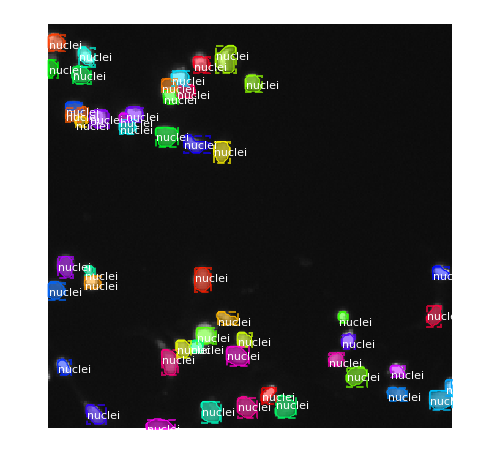

In [13]:
# Test on a random image
image_id = random.choice(dataset_val.image_ids)
original_image, image_meta, gt_class_id, gt_bbox, gt_mask =\
    modellib.load_image_gt(dataset_val, inference_config, 
                           image_id, use_mini_mask=False)

log("original_image", original_image)
log("image_meta", image_meta)
log("gt_class_id", gt_class_id)
log("gt_bbox", gt_bbox)
log("gt_mask", gt_mask)

visualize.display_instances(original_image, gt_bbox, gt_mask, gt_class_id, 
                            dataset_train.class_names, figsize=(8, 8))

Processing 1 images
image                    shape: (256, 256, 3)         min:   10.00000  max:  255.00000
molded_images            shape: (1, 256, 256, 3)      min: -113.70000  max:  151.10000
image_metas              shape: (1, 10)               min:    0.00000  max:  256.00000


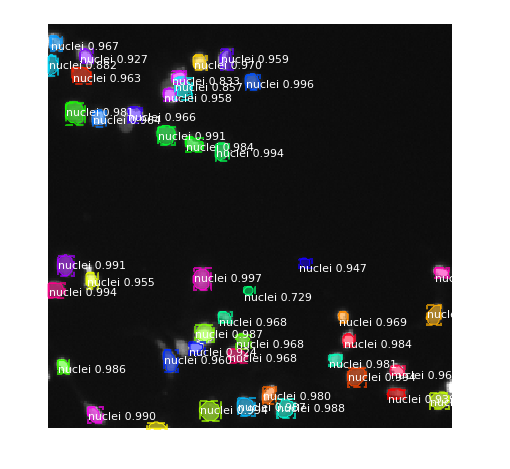

In [14]:
results = model.detect([original_image], verbose=1)

r = results[0]
visualize.display_instances(original_image, r['rois'], r['masks'], r['class_ids'], 
                            dataset_val.class_names, r['scores'], ax=get_ax())

## Evaluation

In [15]:
# Compute VOC-Style mAP @ IoU=0.5
# Running on 10 images. Increase for better accuracy.
image_ids = dataset_val.image_ids 
APs = []
for image_id in image_ids:
    # Load image and ground truth data
    image, image_meta, gt_class_id, gt_bbox, gt_mask =\
        modellib.load_image_gt(dataset_val, inference_config,
                               image_id, use_mini_mask=False)
    molded_images = np.expand_dims(modellib.mold_image(image, inference_config), 0)
    # Run object detection
    results = model.detect([image], verbose=0)
    r = results[0]
    # Compute AP
    AP, precisions, recalls, overlaps =\
        utils.compute_ap(gt_bbox, gt_class_id, gt_mask,
                         r["rois"], r["class_ids"], r["scores"], r['masks'])
    APs.append(AP)
    
print("mAP: ", np.mean(APs))

mAP:  0.7578427944012168
